In [39]:
from langchain_community.document_loaders import RecursiveUrlLoader

import re

from bs4 import BeautifulSoup


def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()

loader = RecursiveUrlLoader(
    "https://docs.chaicode.com/",
    max_depth=500,
    extractor=bs4_extractor
)

docs = loader.load()
print("docs made")



docs made


In [40]:
print(len(docs))
docs

83


[Document(metadata={'source': 'https://docs.chaicode.com/', 'content_type': 'text/html; charset=UTF-8', 'title': 'Home | Chai aur Docs', 'description': 'Level up your learning ChaiDocs.', 'language': 'en'}, page_content='Home | Chai aur Docs\n  Skip to content        Chai aur Docs        YouTube Instagram LinkedIn GitHub X                                          Docs You’ll  Actually Read Next-gen docs that builds reading habits into your workflow.     Start Learning     Watch Tutorials       \n Have a question or want to get involved..?    Join our Discord     \n  Brought to you by ChaiCode            Chai aur Code is an unique initiative by Hitesh Choudhary where he mentors people who want to learn programming and grow in the field.Learn about ChaiCode         \nContribute\n    \nCommunity\n   \nSponsor'),
 Document(metadata={'source': 'https://docs.chaicode.com/contribute/guide', 'content_type': 'text/html; charset=UTF-8', 'title': 'Before You Start | Chai aur Docs', 'description':

In [41]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
splitted_docs = text_splitter.split_documents(docs)
print(len(splitted_docs))

splitted_docs[0]

837


Document(metadata={'source': 'https://docs.chaicode.com/', 'content_type': 'text/html; charset=UTF-8', 'title': 'Home | Chai aur Docs', 'description': 'Level up your learning ChaiDocs.', 'language': 'en'}, page_content='Home | Chai aur Docs\n  Skip to content        Chai aur Docs        YouTube Instagram LinkedIn GitHub X                                          Docs You’ll  Actually Read Next-gen docs that builds reading habits into your workflow.     Start Learning     Watch Tutorials       \n Have a question or want to get involved..?    Join our Discord     \n  Brought to you by ChaiCode            Chai aur Code is an unique initiative by Hitesh Choudhary where he mentors people who want to learn programming and grow in the field.Learn about ChaiCode         \nContribute\n    \nCommunity\n   \nSponsor')

In [43]:
for doc in splitted_docs:
    if doc.metadata:
        # Remove keys with None values
        doc.metadata = {k: v for k, v in doc.metadata.items() if v is not None}

In [44]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")


vector = embeddings.embed_query("hello")
vector[:5]

[0.048244964331388474,
 0.011776605620980263,
 -0.01155206747353077,
 -0.018164537847042084,
 -0.002611024072393775]

In [45]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

vector_store = Chroma.from_documents(splitted_docs,embeddings)

In [46]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

response = llm.invoke("who is prime minister of india")
response.content

'The current Prime Minister of India is Narendra Modi.'

In [47]:
from langchain_core.prompts import PromptTemplate

template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking! " at the end of the answer.

{context}

Question: {question}
Helpful answer: 
"""

prompt = PromptTemplate.from_template(template)

In [48]:
from langchain import hub
hubprompt = hub.pull("rlm/rag-prompt")
hubprompt


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [49]:
from typing_extensions import List, TypedDict
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [59]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=3)
    return {"context": retrieved_docs}


In [60]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = hubprompt.invoke({"question":state["question"],"context":docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [61]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve,generate])
graph_builder.add_edge(START,"retrieve")
graph = graph_builder.compile()

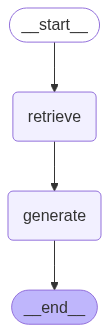

In [53]:
from IPython.display import Image , display
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
response = graph.invoke({"question": "git and git hub ke baare me batao and how to make new branch provide code or example"})
print("Answer: ",response.get("answer"))
unique_sources = set()

for doc in response["context"]:
    source = doc.metadata.get("source")
    if source:
        normalized_source = source.rstrip("/")  # Removes trailing slash
        unique_sources.add(normalized_source)

sorted_sources = sorted(unique_sources)
print("sources:", sorted_sources) 


Answer:  Git and GitHub are used for version control, allowing multiple developers to work on different features simultaneously using branches. To create a new branch, you can use the command `git checkout -b <branch_name>`. The HEAD in Git points to the current branch you are working on.
sources: ['https://docs.chaicode.com/youtube/chai-aur-git/branches', 'https://docs.chaicode.com/youtube/chai-aur-sql/joins-exercise', 'https://docs.chaicode.com/youtube/getting-started']
